In [1]:
# Load packages

import pandas as pd
import altair as alt
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import shapely.wkt
import pandas_profiling

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

# source: https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html

DataTransformerRegistry.enable('json')

In [2]:
url = 'https://data.cityofnewyork.us/api/views/vfnx-vebw/rows.csv'

squirrel_data = pd.read_csv(url, usecols = ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color', 'Location', 'Kuks', 'Quaas', 'Moans', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Approaches', 'Indifferent', 'Runs from', 'Lat/Long'])
# source (data): https://catalog.data.gov/dataset/2018-central-park-squirrel-census-hectare-data

In [3]:
squirrel_data = squirrel_data.fillna(value = "Unknown")

In [4]:
# Convert lat/long column of squirrel data from string to point
squirrel_data["Lat/Long"] = squirrel_data["Lat/Long"].apply(shapely.wkt.loads)

In [5]:
# Load data needed to map data on park map
geojson_filepath = '../data/central_park_geo.geojson'

def open_geojson(path):
    """
    Opens a geojson file at "path" filepath
    """
    with open(path) as json_data:
        d = json.load(json_data)
    return d

def get_geopandas_df(path):
    """
    Creates geopandas dataframe from geeojson file 
    at "path" filepath
    """
    open_json = open_geojson(path)
    gdf = gpd.GeoDataFrame.from_features((open_json))
    return gdf

# Create geopandas dataframe from Central Park geoJson file
gdf = get_geopandas_df(geojson_filepath)



# source (code): https://medium.com/dataexplorations/creating-choropleth-maps-in-altair-eeb7085779a1
# source (map data): https://data.cityofnewyork.us/City-Government/Parks-Zones/rjaj-zgq7

In [6]:
gdf.at[list(gdf.query('location == "CPW, W 97 St, West Drive, W 100 St"').index), 'sitename'] = 'Central Park West (Zone 1)'
gdf.at[list(gdf.query('location == "CPW, 85 St Transverse, West Drive To 96 St"').index), 'sitename'] = 'Central Park West (Zone 2)'
gdf.at[list(gdf.query('location == "66 St To 72 St, CPW To West Drive"').index), 'sitename'] = 'Central Park West (Zone 3)'
gdf.at[list(gdf.query('location == "West Drive, CPW, 65 St Transverse"').index), 'sitename'] = 'Central Park West (Zone 4)'

In [7]:
# Map 'sitename' from mapping data to location of each squirrel observation
# in 'squirrel_data'
squirrel_data["sitename"] = "not set"

def map_park_site(point):
    """
    Matches point location of observation in squirrel_data to polygon
    in gdf that it lies within. Returns "sitename" of polygon.
    
    Parameters
    ----------
    point
        shapely.point object
    
    Returns
    -------
    string
        sitename value of polygon that point lies within
        
    Examples
    --------
    map_park_site(Point((73, 43)))
    > "Great Lawn"
    -------------
    """
    for poly in gdf["geometry"]:
        if point.within(poly):
            i = list(gdf['sitename'].loc[gdf['geometry'] == poly])
            val = i[0]
            return val

# Map sitename to polygons
squirrel_data['sitename'] = squirrel_data['Lat/Long'].apply(map_park_site)

In [8]:
squirrel_data.columns = [col.replace(' ','_') for col in list(squirrel_data.columns)]

In [9]:
# Prepare data to explore squirrel activity by time of day AND sitename
# Group total squirrel count by shift and site
squirrel_group_shift = (squirrel_data[['sitename','Unique_Squirrel_ID', 'Shift']]
                        .groupby(['sitename','Shift'])
                        .count()
                        .reset_index())
squirrel_shift_am = squirrel_group_shift.query('Shift == "AM"')
squirrel_shift_pm = squirrel_group_shift.query('Shift == "PM"')
# Merge basemap data with grouped squirrel data
squirrel_shift_diff = pd.merge(squirrel_shift_am, squirrel_shift_pm, on = 'sitename', how = 'outer')
# Calculate change in squirrel count in afternoon vs. morning
squirrel_shift_diff['Shift_difference'] = squirrel_shift_diff['Unique_Squirrel_ID_y']-squirrel_shift_diff['Unique_Squirrel_ID_x']
# Name columns
squirrel_shift_diff.columns = ['sitename', 
                               'Shift_AM', 
                               'AM Squirrel Count', 
                               'Shift_PM', 
                               'PM Squirrel Count', 
                               'Count_difference']
squirrel_shift_diff = squirrel_shift_diff[['sitename','AM Squirrel Count', 'PM Squirrel Count', 'Count_difference']]

In [10]:
# Prepare squirrel data to graph squirrel counts by park area
squirrel_group_count = squirrel_data[['sitename','Unique_Squirrel_ID']].groupby('sitename').count().reset_index()

# Merge base map data with squirrel data
squirrel_geo_count = pd.merge(gdf, squirrel_group_count, on = 'sitename')

# Add column with Count differences (AM vs. PM)
squirrel_geo_count = pd.merge(squirrel_geo_count, squirrel_shift_diff, on = 'sitename')

# Account for multiple "Central Park West" values
# squirrel_geo_count.at[10, 'sitename'] = "Central Park West (Zone 1)"
# squirrel_geo_count.at[11, 'sitename'] = "Central Park West (Zone 2)"
# squirrel_geo_count.at[12, 'sitename'] = "Central Park West (Zone 3)"
# squirrel_geo_count.at[13, 'sitename'] = "Central Park West (Zone 4)"
squirrel_geo_count = squirrel_geo_count.sort_values('Unique_Squirrel_ID')

In [11]:
# Add shortened sitenames for plots

sitename_short_dict = {'Bendheim Plgd' : 'Bendheim Plgd',
'Pat Hoffman Friedman Plgd' : 'P.H.F. Plgd',
'110th St & Lenox Ave Plgd' : '110th St. Plgd',
'Heckscher Plgd' : 'Heckscher Plgd',
'Conservatory Garden' : 'Cons. Garden',
'Northwest Corner' : 'Northwest Corner',
'Reservoir (Southeast)' : 'Reservoir SE',
'Strawberry Fields' : 'Strawberry Fields',
"Frawleys' Run" : "Frawleys' Run",
'The Great Hill' : 'The Great Hill',
"Nutter's Battery & Fort Clinton Site" : "Nutter's Battery",
'The Metropolitan Museum Of Art' : 'The Met',
'Wollman Rink' : 'Wollman Rink',
'79th St Yard And Summit Rock' : 'Summit Rock',
'Pilgrim Hill & Conservatory Water' : 'Pilgrim Hill',
'Wien Walk And Arsenal' : 'Wien Walk',
'Reservoir (Northeast)' : 'Reservior NE', 
'Belvdre. Cstl., Turtle Pond, Shkspr Grdn' : 'Turtle Pond Area',
'Dairy, Chess & Checkers House, Carousel' : 'Carousel Area',
'East Meadow' : 'E Meadow',
'North Of The Arsenal' : 'N of the Arsenal',
'Cedar Hill' : 'Cedar Hill',
'Conservatory Gardens West Landscape' : 'Cons. Gardens W.',
'Hallett Nature Sanctuary And Pond' : 'Hallett Nat. Sanc.',
'Loch Ravine' : 'Loch Ravine',
'Wallach Walk And East Green' : 'Wallach Walk',
'Reservoir (Northwest)' : 'Reservoir NW',
'North Meadow Recreation Center' : 'N Meadow Rec. Ctr.',
'Ross Pinetum' : 'Ross Pinetum',
"Great Lawn And Cleopatra's Needle" : 'Great Lawn',
'Central Park South' : 'Central Park S.',
'Blockhouse One' : 'Blockhouse One',
'Sheep Meadow' : 'Sheep Meadow',
'The Mall And Rumsey Playfield' : 'The Mall',
'North Meadow' : 'N Meadow',
'The Pool' : 'The Pool',
'Bethesda Terrace' : 'Bethesda Terrace',
'Heckscher Ballfields & Playground' : 'Hecksher Ballfields',
'Central Park West (Zone 1)' : 'Central Park W (Z-1)',
'Central Park West (Zone 3)' : 'Central Park W (Z-2)',
'Central Park West (Zone 2)' : 'Central Park W (Z-3)',
'Central Park West (Zone 4)' : 'Central Park W (Z-4)',
'The Ramble' : 'The Ramble',
'The Tarr-Coyne Tots Playground': 'T.C.T Plgd',
'Reservoir Running Track & Landscape': 'Res. Running Track',
"Bernard Plgd":'Bernard Plgd',
'James Michael Levin Plgd': 'J.M.L. Plgd',
"Mariner's Gate Plgd": "Mariner's Gate Plgd"}

squirrel_geo_count['sitename_short'] = squirrel_geo_count['sitename'].replace(sitename_short_dict)

In [12]:
# Convert geopandas dataframe to format
# plottable in Altair
alt_json_count = json.loads(squirrel_geo_count.to_json())
alt_base_layer_data_count = alt.Data(values = alt_json_count['features'])
# source (code): https://medium.com/dataexplorations/creating-choropleth-maps-in-altair-eeb7085779a1

In [13]:
################# TOTAL SQUIRREL COUNT AM vs. PM

# Prepare data to explore squirrel behavior and activity by time of day (shift -- AM vs. PM)
# Group total squirrel count and behaviors by shift
squirrel_count_shift = (squirrel_data[['Shift',
                                       'Unique_Squirrel_ID', 
                                       ]]
                        .groupby('Shift')
                        .count()
                        .reset_index())
#squirrel_count_shift

In [14]:
# Prepare data to plot behavior counts per park area
squirrel_b = (squirrel_data[['sitename','Unique_Squirrel_ID','Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas',
       'Moans', 'Approaches']]
                        .groupby(['sitename'])
                        .agg({'Running':'sum', 
                              'Chasing':'sum', 
                              'Climbing':'sum', 
                              'Eating':'sum', 
                              'Foraging':'sum', 
                              'Kuks':'sum', 
                              'Quaas':'sum',
                              'Moans':'sum', 
                              'Approaches':'sum', 
                             })
                        .reset_index())

# Sum all vocalizations
squirrel_b['Vocalizing'] = squirrel_b['Kuks'] + squirrel_b['Quaas'] + squirrel_b['Moans']

# Rename "Approaches" as "Approaches Humans"
squirrel_b = squirrel_b.rename(columns = {'Approaches' : 'Approaches Humans'})

# Sum Eating and Foraging
squirrel_b['Eating_or_Foraging'] = squirrel_b['Eating'] + squirrel_b['Foraging']

# Sum Running and Chasing
squirrel_b['Running_or_Chasing'] = squirrel_b['Running'] + squirrel_b['Chasing']


# squirrel_b = squirrel_b.melt(id_vars = 'sitename', 
#                                      value_vars = ['Running or Chasing', 
#                                                    'Climbing', 
#                                                    'Eating or Foraging', 
#                                                    'Vocalizing', 
#                                                    'Approaches Humans'], 
#                                      var_name = 'behavior', 
#                                      value_name = 'b_count')

squirrel_b_geo = pd.merge(gdf, squirrel_b, on = 'sitename')
squirrel_b_geo['sitename_short'] = squirrel_b_geo['sitename'].replace(sitename_short_dict)

In [15]:
b_json_count = json.loads(squirrel_b_geo.to_json())
squirrel_b_json = alt.Data(values = b_json_count['features'])

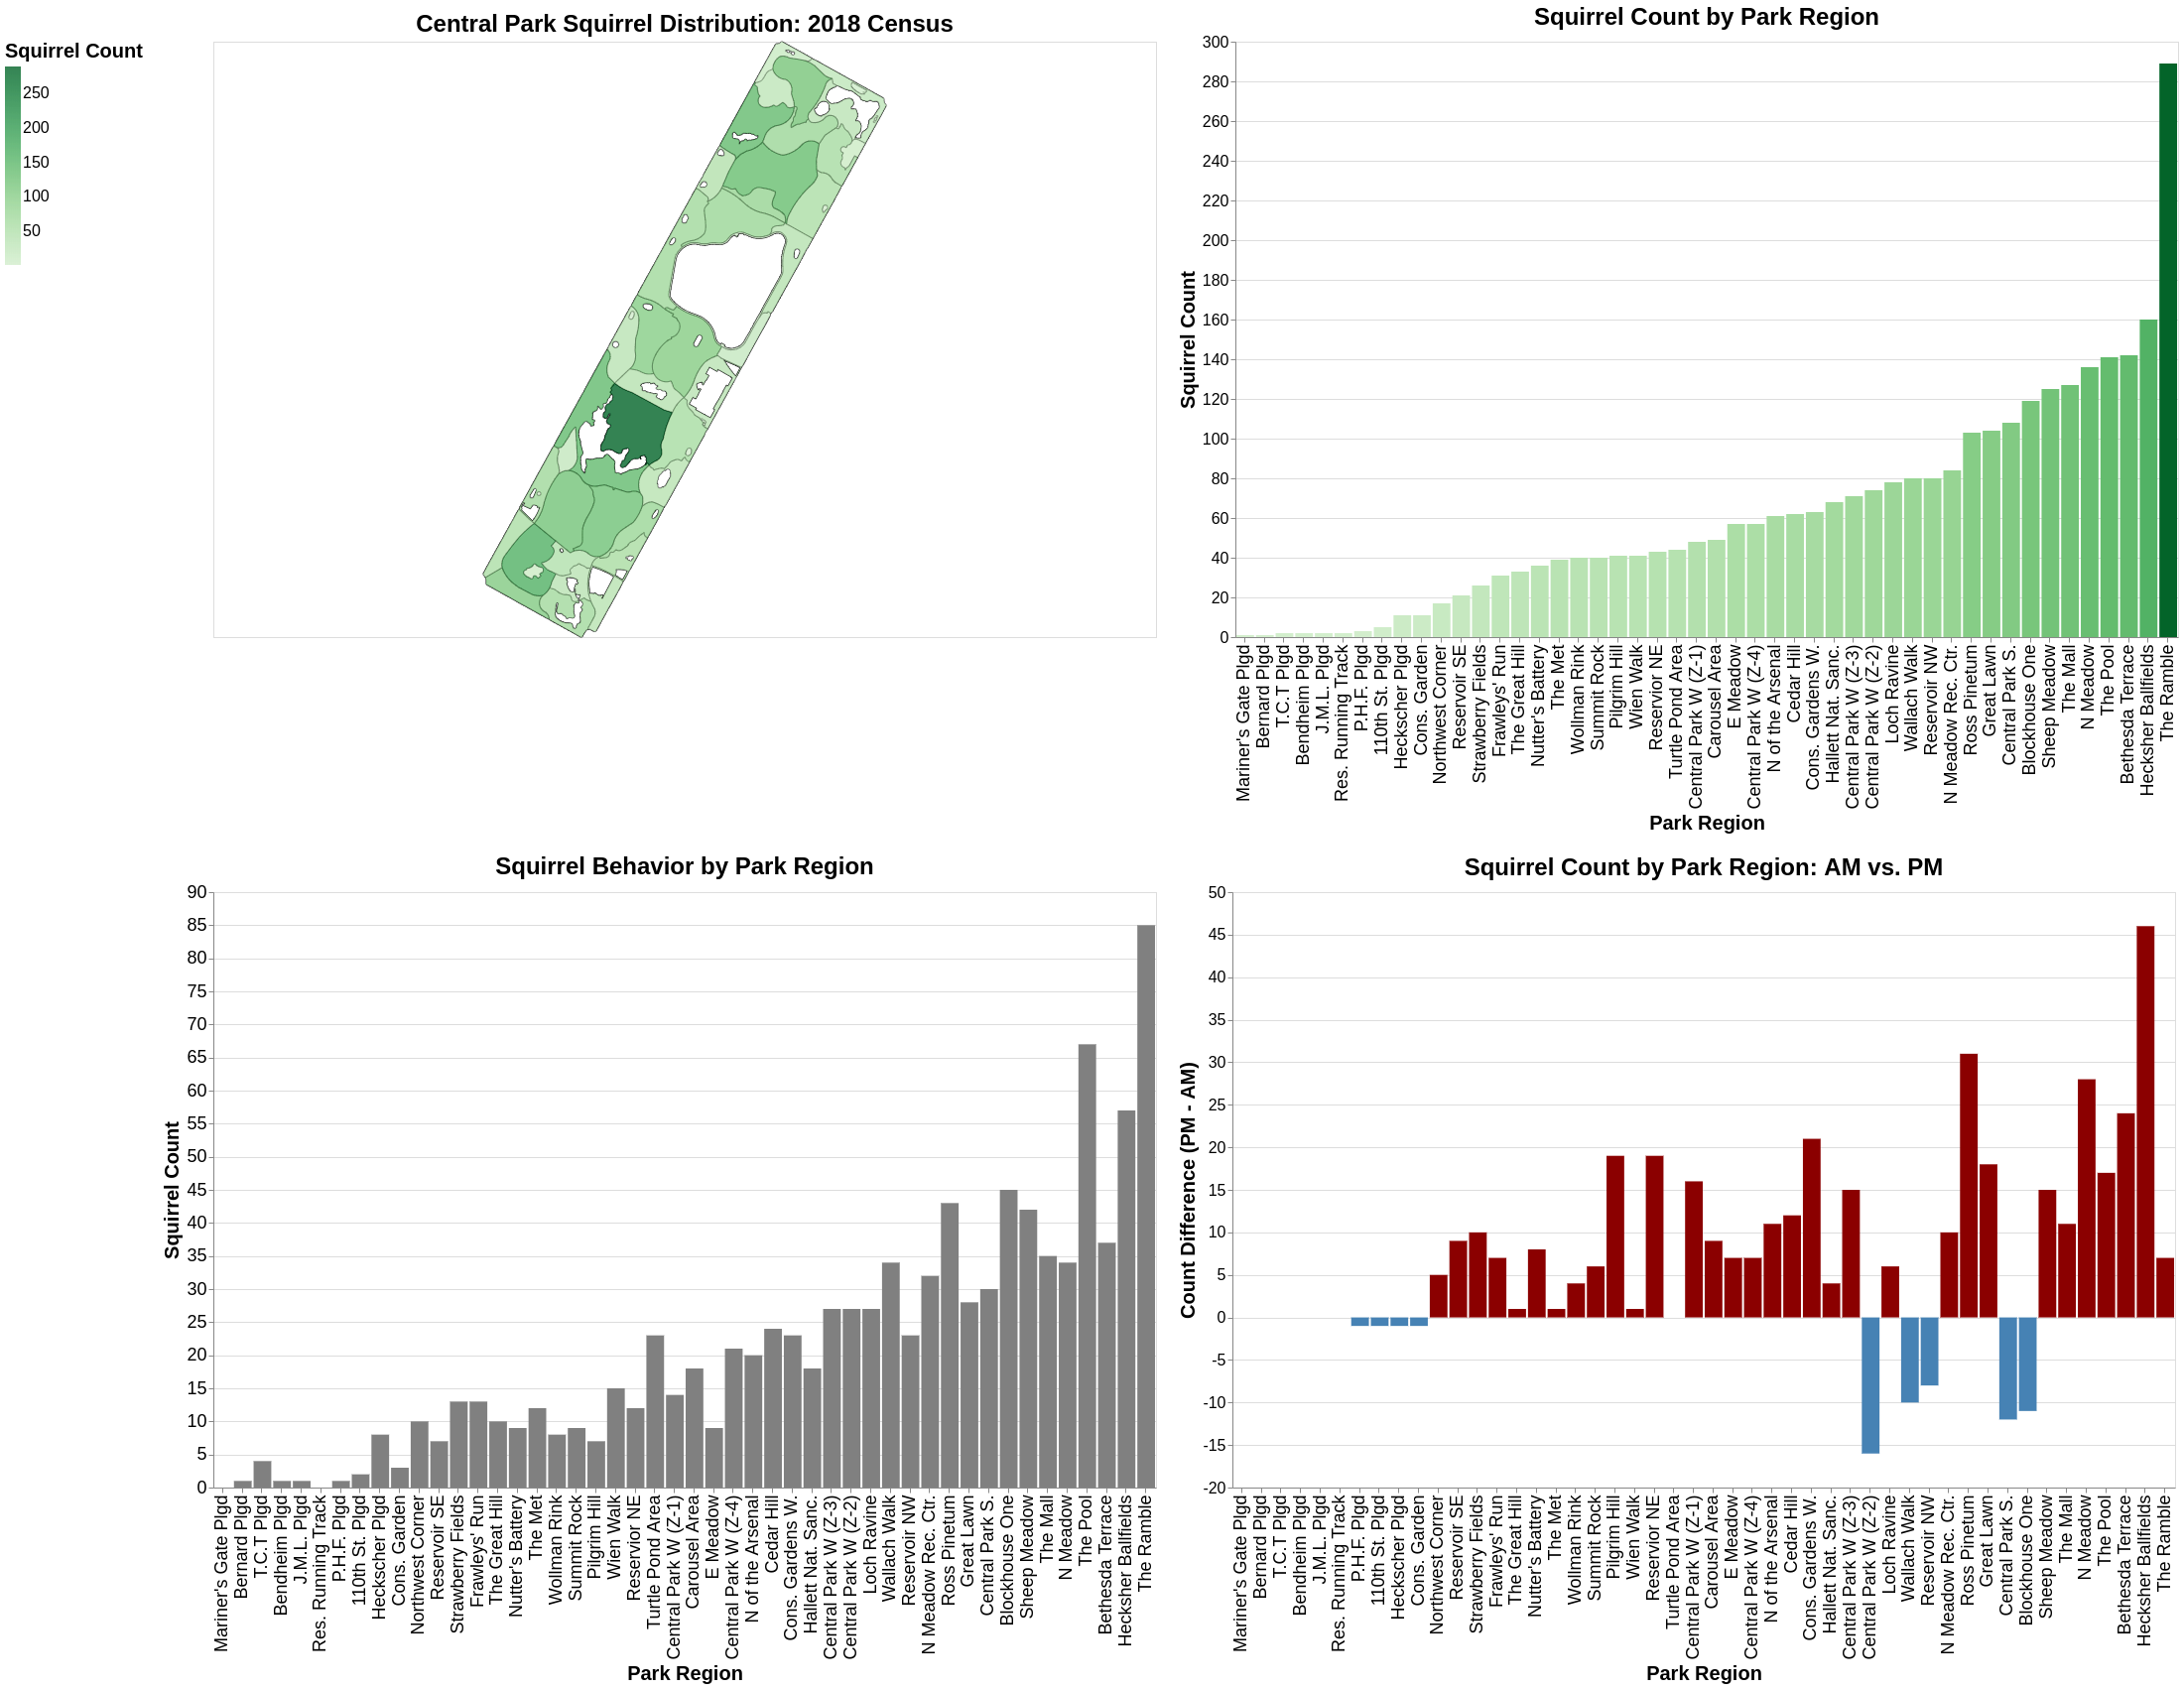

In [16]:
##################################
# PLOT MAP of SQUIRREL COUNT
##################################

def plot_map_total_count(selection):
    # Plot of squirrel count
    base_map = alt.Chart(alt_base_layer_data_count).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=950,
        height=600
    )

    # Add Choropleth Layer
    choropleth = (alt.Chart(alt_base_layer_data_count, 
                            title = "Central Park Squirrel Distribution: 2018 Census")
    .mark_geoshape()
    .add_selection(selection)
    .encode(
    # SELECTION SINGLE CONDITIONS -- Color is grey if not selected
        color = alt.condition(selection, 
                              'properties.Unique_Squirrel_ID:Q', 
                              alt.value('grey'),
            title = 'Squirrel Count',
            scale=alt.Scale(scheme='greens'),
            legend = alt.Legend(labelFontSize = 16, 
                                titleFontSize = 20, 
                                tickCount = 5,
                               orient = "left")),
        opacity=alt.condition(selection, 
                              alt.value(0.8), 
                              alt.value(0.1)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")]
    ))
    
    return(base_map + choropleth)

# Sort data by squirrel count to display sites in ascending order
sort_order = list(squirrel_geo_count['sitename_short'])

##########################################
# PLOT TOTAL SQUIRREL COUNT
##########################################
def plot_bar_total_count(selection):
    count_bar = (alt.Chart(alt_base_layer_data_count, 
                           title = 'Squirrel Count by Park Region')
    .mark_bar()
    .add_selection(selection)
    .encode(
        x = alt.X('properties.sitename_short:N', 
                  title = "Park Region", 
                  axis = alt.Axis(labelFontSize = 18,
                                  titleFontSize = 20), 
                  sort = sort_order),
        y = alt.Y('properties.Unique_Squirrel_ID:Q', 
                  title = "Squirrel Count", 
                  axis = alt.Axis(labelFontSize = 16, 
                                  titleFontSize = 20)),
        color = alt.Color('properties.Unique_Squirrel_ID:Q',
                         scale=alt.Scale(scheme='greens')),

    # SELECTION SINGLE CONDITIONS -- opacity is 0.2 if not selected
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")])
    .properties(width = 950, height = 600))   
    return(count_bar)

################################################
# PLOT DIFFERENCE in COUNT by TIME OF DAY
################################################
def plot_bar_count_diff(selection):
    area_count_shift = (alt.Chart(alt_base_layer_data_count)
    .mark_bar()
    .add_selection(selection)
    .encode(
        alt.X('properties.sitename_short:N',
              axis = alt.Axis(labelFontSize = 18,
                                           titleFontSize = 20), 
              title = "Park Region",
              sort = sort_order),
        alt.Y('properties.Count_difference:Q', 
              title = "Count Difference (PM - AM)", 
              axis = alt.Axis(labelFontSize = 16, 
                              titleFontSize = 20)),
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        color=alt.condition(
            # If count is negative, color bar blue. If positive, red.
            alt.datum['properties.Count_difference'] > 0,
            alt.value("darkred"),  # The positive color
            alt.value("steelblue")  # The negative color
        ),
        tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                   alt.Tooltip('properties.Count_difference:Q', title="Count difference")]
    ).properties(title = "Squirrel Count by Park Region: AM vs. PM",
                 width = 950,
                height = 600))
    return(area_count_shift)


###################################
# PLOT BEHAVIOR by PARK AREA
###################################
def plot_bar_behavior(selection):
    #b = ['Running or Chasing', 'Climbing', 'Eating or Foraging', 'Vocalizing', 'Approaches Humans']
    #b_dropdown = alt.binding_select(options=b)
    #b_select = alt.selection_single(fields=['properties.behavior'], 
    #                                bind = b_dropdown, name="Squirrel", 
    #                                init = {'properties.behavior' : 'Running or Chasing'})

    b_chart = (alt.Chart(squirrel_b_json)
        .mark_bar(color = 'gray')
        #.add_selection(b_select)
        .add_selection(selection)
        .encode(alt.X('properties.sitename_short:N', title = "Park Region", sort = sort_order, axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)), 
                alt.Y('properties.Running_or_Chasing:Q', title = 'Squirrel Count', axis = alt.Axis(labelFontSize = 18,
                                                   titleFontSize = 20)),
                opacity = alt.condition(brush, 
                                    alt.value(1.0), 
                                    alt.value(0.2)),
                tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                           alt.Tooltip('properties.b_count:Q', title="Squirrel Count")]
               )
        #.transform_filter(b_select)
        .properties(title = "Squirrel Behavior by Park Region",
                     width = 950,
                    height = 600))
    return b_chart


# Create selection conditions and link plots by setting resolve = 'global'
brush = alt.selection_multi(fields = ['properties.sitename_short'],
    resolve='global'
)


# Render stacked plots
((plot_map_total_count(brush) | plot_bar_total_count(brush)) & (plot_bar_behavior(brush) | plot_bar_count_diff(brush))).configure_title(fontSize = 24)

# source (code): https://www.districtdatalabs.com/altair-choropleth-viz